# Munge national shapefile

thinking through the array steps:
https://stackoverflow.com/questions/31820107/is-there-a-numpy-function-that-allows-you-to-specify-start-step-and-number

keep doing intersects and then for each shape left over, find the one with the point therein?
https://gis.stackexchange.com/questions/455159/cut-a-polygon-based-on-lines-from-another-layer-in-geopandas

conic albers, a projection for the lower 48 that maintains area equality
https://epsg.org/crs_5072/NAD83-NSRS2007-Conus-Albers.html?sessionkey=nb47agmo4r

shapely subtraction
https://stackoverflow.com/questions/61930060/how-to-use-shapely-for-subtracting-two-polygons

standard guage railway is 1,435 mm-- here, we'll round to 1.5 m wide
https://en.wikipedia.org/wiki/Standard-gauge_railway

In [1]:
import pandas as pd
import geopandas as gpd
# from haversine import inverse_haversine, Unit, Direction, haversine
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, box, LineString
# from tqdm.notebook import tqdm
# from itertools import compress
# from skimage.measure import grid_points_in_poly, points_in_poly
# from ray import train, tune

# Conic, equal-area map projection; meters in lieu of geodetic coords
target_epsg = 6350  # https://epsg.org/crs_6350/NAD83-2011-Conus-Albers.html?sessionkey=nb47agmo4r

In [2]:
fn_coords = '/Volumes/Extreme SSD/largest_plots/raw_data/colo_sites(202409301939).csv'
CoordsRaw = pd.read_csv(fn_coords)

# Set up area of interests

In [3]:
geometry = [Point(xy) for xy in zip(CoordsRaw.longitude, CoordsRaw.latitude)]
Coords = gpd.GeoDataFrame(CoordsRaw, geometry=geometry)
Coords.set_crs(epsg=4326, inplace=True)  # Default used in GPS https://epsg.io/4326#google_vignette
Coords.to_crs(epsg=target_epsg, inplace=True)

# Create 'buffers', aka, areas of interest
aoi_list = Coords.buffer(1e3*50, cap_style='square')  # Necessary to turn a pt into a square
Aoi = gpd.GeoDataFrame({'aoi':aoi_list})
Aoi.set_geometry('aoi', inplace=True)
Aoi.set_crs(epsg=target_epsg, inplace=True)
Aoi.head()

,aoi
0,"POLYGON ((1064783.733 1251341.503, 1064783.733..."
1,"POLYGON ((1253970.757 1246193.050, 1253970.757..."
2,"POLYGON ((1280030.297 1420238.314, 1280030.297..."
3,"POLYGON ((1652992.164 1570284.428, 1652992.164..."
4,"POLYGON ((1517647.954 1484669.498, 1517647.954..."


In [4]:
# Sanity check-- are these buffer areas correct?
all(
    Aoi.area.round() == 
    (1e3*50*2)**2
)

True

# National boundary

In [18]:
fn_nation_shape = '/Volumes/Extreme SSD/largest_plots/raw_data/cb_2021_us_all_5m/cb_2021_us_nation_5m.zip'
NationShape = gpd.read_file(fn_nation_shape).to_crs(epsg=target_epsg)
NationShape.head()

,AFFGEOID,GEOID,NAME,geometry
0,0100000US,US,United States,"MULTIPOLYGON (((-5215608.250 5698763.159, -521..."


In [24]:
nationshape_overlay = gpd.overlay(Aoi.loc[[i]], NationShape, how='intersection')['geometry']

In [25]:
# is_max_area = NationShapeOverlay.area.round() == NationShapeOverlay.area.round().max()

# maps = {True: "black", False: "red"}
# NationShapeOverlay['color'] = [maps[value] for value in is_max_area.values]


# fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_xlim(-.3e7, .3e7)
# ax.set_ylim(0, .35e7)
# NationShape.plot(ax=ax, color='blue')
# NationShapeOverlay.plot(ax=ax, color = NationShapeOverlay['color'])
# plt.show()

del NationShape

# Experiment on lines

In [8]:
s = gpd.GeoSeries(LineString(
    [(0, 0), (0, 10)]
    )
)
s.buffer(distance=1, cap_style='flat').area

0    20.0
dtype: float64

## Rails

In [9]:
fn_rails = '/Volumes/Extreme SSD/largest_plots/raw_data/tl_2023_us_rails.zip'
Rails = gpd.read_file(fn_rails).to_crs(epsg=target_epsg)

In [10]:
i = 0
RailSubset = gpd.sjoin(Rails, Aoi.loc[[i]], how='inner', predicate='intersects')

In [12]:
# Add buffer to lines
RailPolygons = RailSubset.buffer(distance=1000, cap_style='round', single_sided=False)  # TODO: delete this
# RailPolygons = RailSubset.buffer(distance=0.75, cap_style='round')  # TODO: use this # round prevents breaks in the lines

In [13]:
rail_polygon_flat = RailPolygons.unary_union

<Axes: >

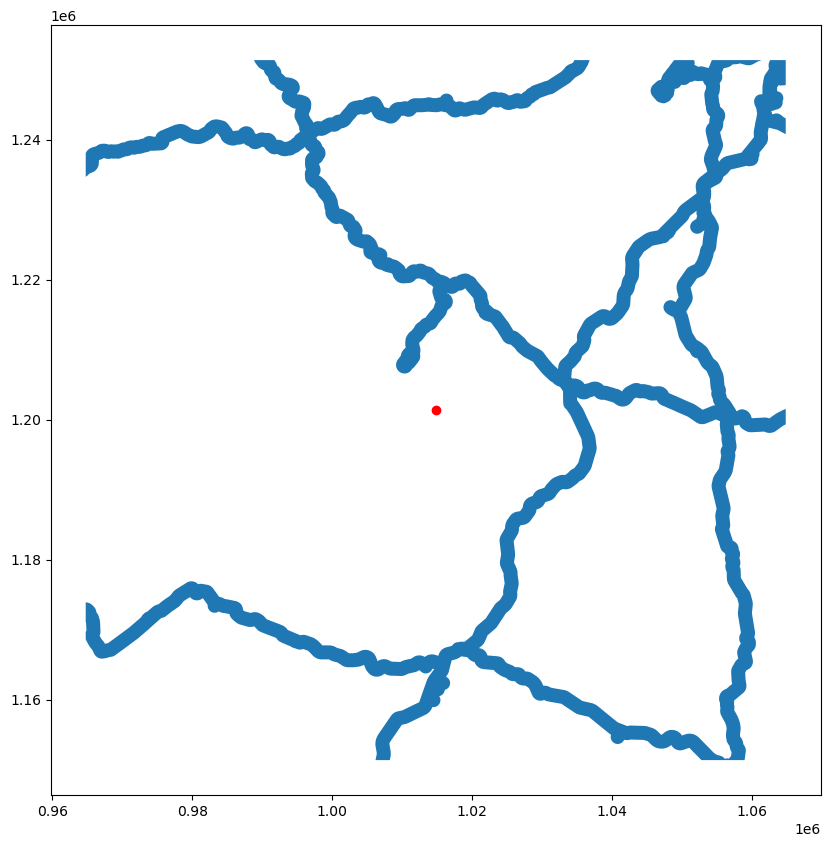

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
gpd.GeoSeries(rail_overlay).plot(ax=ax)
Coords.loc[[i]].plot(ax=ax, color = 'red')

In [17]:
rail_overlay = Aoi.aoi[i].intersection(rail_polygon_flat)

# ensure we can create the final shape right

In [38]:
nationshape_overlay.area

0    1.000000e+10
dtype: float64

In [54]:
ExplodedCulmination = gpd.GeoDataFrame({'geometry':nationshape_overlay.difference(rail_overlay)}).set_geometry('geometry').explode(index_parts=False)

<Axes: >

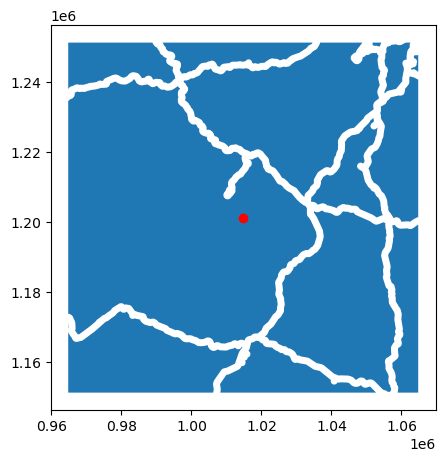

In [68]:
fig, ax = plt.subplots(figsize=(5, 5))
ExplodedCulmination.plot(ax=ax)
Coords.loc[[i]].plot(ax=ax, color='red')

In [85]:
join_results = gpd.sjoin(Coords.loc[[i]], ExplodedCulmination, predicate='within', how='right')['index_left'].isna()

color_dict = {True:'red', False:'blue'}
color_list = [color_dict[value] for value in join_results]

<Axes: >

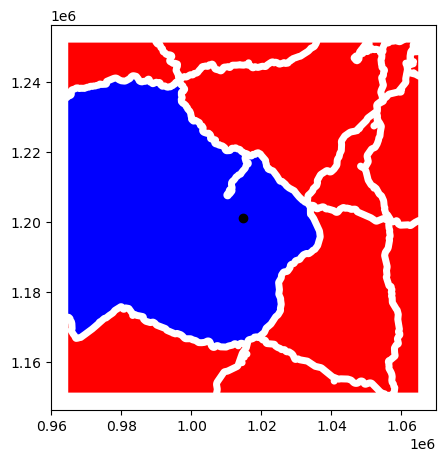

In [86]:
fig, ax = plt.subplots(figsize=(5, 5))
ExplodedCulmination.plot(ax=ax, color = color_list)
Coords.loc[[i]].plot(ax=ax, color='black')

In [3]:
fn_area_water = '/Volumes/Extreme SSD/largest_plots/raw_data/area_water/tl_2023_01001_areawater.zip'
AreaWater = gpd.read_file(fn_area_water)

In [4]:
AreaWater

,ANSICODE,HYDROID,FULLNAME,MTFCC,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,None,110585123246,None,H2030,0,1058,+32.4475829,-86.7287169,"POLYGON ((-86.72889 32.44744, -86.72886 32.447..."
1,None,110585122713,Motley Pond,H2030,0,19810,+32.4854734,-86.6282779,"POLYGON ((-86.62903 32.48538, -86.62890 32.485..."
2,None,110585122709,Swift Crk,H2030,0,1185120,+32.4107383,-86.6320375,"POLYGON ((-86.64343 32.43036, -86.64342 32.430..."
3,None,110585122725,Alabama Riv,H3010,0,1361299,+32.3952613,-86.8385000,"POLYGON ((-86.85780 32.43968, -86.85768 32.439..."
4,None,110585122766,White Water Lk,H2030,0,232895,+32.4690021,-86.6388877,"POLYGON ((-86.64170 32.46588, -86.64136 32.466..."
...,...,...,...,...,...,...,...,...,...
604,None,110585122928,None,H2030,0,4264,+32.4168944,-86.4707801,"POLYGON ((-86.47120 32.41708, -86.47119 32.417..."
605,None,110585123087,None,H2030,0,3518,+32.4471441,-86.4902889,"POLYGON ((-86.49070 32.44708, -86.49066 32.447..."
606,None,110585123097,None,H2030,0,1111,+32.4323645,-86.4228744,"POLYGON ((-86.42312 32.43241, -86.42304 32.432..."
607,None,110585123101,None,H2030,0,3655,+32.4211203,-86.4218673,"POLYGON ((-86.42228 32.42120, -86.42224 32.421..."


In [9]:
yy = np.arange(start=24, stop=50, step=8.993999191439993e-06)
xx = np.arange(start=-125, stop=-66, step=2)
# xx = np.arange(start=-125, stop=-66, step=9.291531215312152e-06)

Scikit

In [35]:
y = 34.044727

y_dummy = np.repeat(y, len(xx))
Dummy = pd.DataFrame({
    'y':y,
    'x':xx
})
# grid_points

ValueError: Point() takes only scalar or 1-size vector arguments, got (0    -125
1    -123
2    -121
3    -119
4    -117
5    -115
6    -113
7    -111
8    -109
9    -107
10   -105
11   -103
12   -101
13    -99
14    -97
15    -95
16    -93
17    -91
18    -89
19    -87
20    -85
21    -83
22    -81
23    -79
24    -77
25    -75
26    -73
27    -71
28    -69
29    -67
Name: x, dtype: int64, 0     34.044727
1     34.044727
2     34.044727
3     34.044727
4     34.044727
5     34.044727
6     34.044727
7     34.044727
8     34.044727
9     34.044727
10    34.044727
11    34.044727
12    34.044727
13    34.044727
14    34.044727
15    34.044727
16    34.044727
17    34.044727
18    34.044727
19    34.044727
20    34.044727
21    34.044727
22    34.044727
23    34.044727
24    34.044727
25    34.044727
26    34.044727
27    34.044727
28    34.044727
29    34.044727
Name: y, dtype: float64)

In [28]:
y = 34.044727
# y = 0
point_series = gpd.GeoSeries([Point(x, y) for x in xx])
point_series.crs = 'epsg:4269'
Points = gpd.GeoDataFrame(geometry=point_series)

In [29]:
# mask means 'does the national boundary contain this point'
Join = gdf.sjoin(Points, how="right", predicate='contains')
# does_national_boundary_contain_these_points = ~Join.index_left.isna()

In [106]:
Results = pd.DataFrame()
Results['x'] = list(compress(xx, does_national_boundary_contain_these_points))
Results['y'] = y
Results

,x,y


In [91]:
list(compress(xx, does_national_boundary_contain_these_points))

[-117,
 -115,
 -113,
 -111,
 -109,
 -107,
 -105,
 -103,
 -101,
 -99,
 -97,
 -95,
 -93,
 -91,
 -89,
 -87,
 -85,
 -83,
 -81,
 -79]

In [50]:
Points

0     POINT (-125.00000 34.04473)
1     POINT (-123.00000 34.04473)
2     POINT (-121.00000 34.04473)
3     POINT (-119.00000 34.04473)
4     POINT (-117.00000 34.04473)
5     POINT (-115.00000 34.04473)
6     POINT (-113.00000 34.04473)
7     POINT (-111.00000 34.04473)
8     POINT (-109.00000 34.04473)
9     POINT (-107.00000 34.04473)
10    POINT (-105.00000 34.04473)
11    POINT (-103.00000 34.04473)
12    POINT (-101.00000 34.04473)
13     POINT (-99.00000 34.04473)
14     POINT (-97.00000 34.04473)
15     POINT (-95.00000 34.04473)
16     POINT (-93.00000 34.04473)
17     POINT (-91.00000 34.04473)
18     POINT (-89.00000 34.04473)
19     POINT (-87.00000 34.04473)
20     POINT (-85.00000 34.04473)
21     POINT (-83.00000 34.04473)
22     POINT (-81.00000 34.04473)
23     POINT (-79.00000 34.04473)
24     POINT (-77.00000 34.04473)
25     POINT (-75.00000 34.04473)
26     POINT (-73.00000 34.04473)
27     POINT (-71.00000 34.04473)
28     POINT (-69.00000 34.04473)
29     POINT (

In [49]:
gdf.sjoin(Points)

ValueError: 'right_df' should be GeoDataFrame, got <class 'geopandas.geoseries.GeoSeries'>

In [10]:
gdf.contains(pt0)

0    False
dtype: bool